**Section 1: Wine Dataset**

**Task 1: Load Data and 
Task 2: Splitting the data**

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
dataset = load_wine()
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test= train_test_split(dataset.data , dataset.target, random_state  = 2810)

**Task 3: Cross Validation**

In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
svc = SVC()
print(cross_val_score(svc,X_train, y_train))
print('The Generalisation accuracy is',np.mean(cross_val_score(svc,X_train, y_train)))

[0.66666667 0.66666667 0.66666667 0.73076923 0.73076923]
The Generalisation accuracy is 0.6923076923076923


In [75]:
print('The Cross Val error is',np.mean(1-cross_val_score(svc,X_train, y_train)))

The Cross Val error is 0.30769230769230765


**Task 4: Test Error rate**

In [76]:
svc.fit(X_train,y_train)
print('Test Error rate',1-svc.score(X_test,y_test))

Test Error rate 0.37777777777777777


**The Performance on the Test-set is worse than the performance on Cross_validation sets, this is largely due to small size of training set**

**Task 5:Creating Pipeline with different normalisation and Task 6: Predicting Labels and calculating Test-error rate**

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
pipeline = Pipeline([('scaler',MinMaxScaler()), ('svm',SVC())])

In [58]:
from sklearn.model_selection import GridSearchCV
param_grid ={'svm__C':[0.001,0.01,0.1,1,10,100], 'svm__gamma':[0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(pipeline, param_grid = param_grid, cv =5, n_jobs = -1)
grid.fit(X_train,y_train)
y_pred = grid.predict(X_test)
print('Best Cross_validation accuracy:', grid.best_score_)
print('Test set score:', grid.score(X_test,y_test))
print('Best Parameters:', grid.best_params_)
print('The Test Error rate-',np.mean(y_pred != y_test))

Best Cross_validation accuracy: 1.0
Test set score: 0.9555555555555556
Best Parameters: {'svm__C': 1, 'svm__gamma': 1}
The Test Error rate- 0.044444444444444446


In [59]:
from sklearn.preprocessing import StandardScaler
pipeline = Pipeline([('scaler',StandardScaler()), ('svm',SVC())])
grid = GridSearchCV(pipeline, param_grid = param_grid, cv =5, n_jobs = -1)
grid.fit(X_train,y_train)
y_pred = grid.predict(X_test)
print('Best Cross_validation accuracy:', grid.best_score_)
print('Test set score:', grid.score(X_test,y_test))
print('Best Parameters:', grid.best_params_)
print('The Test Error rate-',np.mean(y_pred != y_test))

Best Cross_validation accuracy: 1.0
Test set score: 0.9333333333333333
Best Parameters: {'svm__C': 1, 'svm__gamma': 0.01}
The Test Error rate- 0.06666666666666667


In [60]:
from sklearn.preprocessing import Normalizer
pipeline = Pipeline([('scaler',Normalizer()), ('svm',SVC())])
grid = GridSearchCV(pipeline, param_grid = param_grid, cv =5, n_jobs = -1)
grid.fit(X_train,y_train)
y_pred = grid.predict(X_test)
print('Best Cross_validation accuracy:', grid.best_score_)
print('Test set score:', grid.score(X_test,y_test))
print('Best Parameters:', grid.best_params_)
print('The Test Error rate-',np.mean(y_pred != y_test))

Best Cross_validation accuracy: 0.9319088319088319
Test set score: 0.9333333333333333
Best Parameters: {'svm__C': 100, 'svm__gamma': 100}
The Test Error rate- 0.06666666666666667


In [61]:
from sklearn.preprocessing import RobustScaler
pipeline = Pipeline([('scaler',RobustScaler()), ('svm',SVC())])
grid = GridSearchCV(pipeline, param_grid = param_grid, cv =5, n_jobs = -1)
grid.fit(X_train,y_train)
y_pred = grid.predict(X_test)
print('Best Cross_validation accuracy:', grid.best_score_)
print('Test set score:', grid.score(X_test,y_test))
print('Best Parameters:', grid.best_params_)
print('The Test Error rate-',np.mean(y_pred != y_test))

Best Cross_validation accuracy: 0.9925925925925926
Test set score: 0.9555555555555556
Best Parameters: {'svm__C': 1, 'svm__gamma': 0.01}
The Test Error rate- 0.044444444444444446


**For Wine Dataset, MinMax appears to be best way to normalise as it is providing the best Cross-Validation accuracy and best Test set score. However,the difference between the performance MinMax and Standard Normalisation is not that big and both of them provide comparable results.Robust Scaler gives test-error rate equal to MinMax Scaler but it has lower Cross-validation accuracy. For the next task, I am going to use MinMax to preprocess data.**

**Task 7: Implementing Cross-Conformal Predictors**

'''For the implementaion of cross-conformal predictors, I have used CV = 5. I have calculated ranks for each caliberation fold and have added the rank for the other caliberation fold using a loop. Since, I have not created an augmented dataset, the way I have found the rank of each test sample for each caliberation set does not require me to subtract one from the rank as this way if my test sample for a given fold is the strangest, the rank will be zero already and hence no need to subtract 1.'''

In [62]:
pipeline = Pipeline([('scaler',MinMaxScaler()), ('svm',SVC())]) #Redefining Pipeline
from sklearn.model_selection import KFold
kf = KFold(shuffle = True, random_state = 2810)
grid1 = GridSearchCV(pipeline, param_grid = param_grid, cv =5, n_jobs = -1)

In [63]:
fold_rank = np.zeros((len(X_test),3))
for rest_index, fold_index in kf.split(X_train):
    X_rest,X_fold = X_train[rest_index], X_train[fold_index]
    y_rest,y_fold = y_train[rest_index], y_train[fold_index]
    conformity_fold = np.zeros(len(y_fold))
    grid1.fit(X_rest,y_rest)
    conformity_scores  = grid1.decision_function(X_fold) 
    test_decision = grid1.decision_function(X_test)
    for i in range(len(y_fold)):
        conformity_fold[i] = conformity_scores[i,y_fold[i]]
    for j in range(len(y_test)):
        for k in range(3):
            fold_rank[j,k] = fold_rank[j,k]+np.sum(test_decision[j,k] >= conformity_fold)
p_value = (fold_rank+1)/(len(X_train)+1)

In [64]:
labels = np.unique(y_train)
pred_targets = np.zeros(len(X_test))
for i in range(len(p_value)):
    pred_targets[i] = labels[np.argmax(p_value[i])]
print('The Test Error-',np.mean(pred_targets != y_test))

The Test Error- 0.044444444444444446


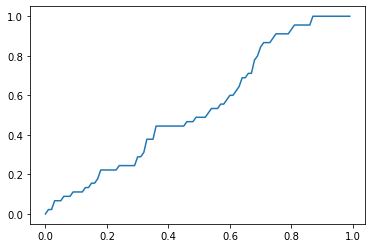

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
eps = np.zeros(100)
err = np.zeros(100)
for k in range(100):
    eps[k] = k/100
    err[k] = 0
    for j in range(len(y_test)):
        if(p_value[j,y_test[j]]<= eps[k]):
            err[k] = err[k]+1
    err[k] = err[k]/len(y_test)
plt.plot(eps,err)

In [66]:
total = 0    
for i in range(len(y_test)):
    k = y_test[i]
    for j in range(len(labels)):
        if k!= j:
            total =total+ p_value[i,j]
avg_false_p = total/(len(p_value)*(len(labels)-1))
print('Avg False P-Value is' ,avg_false_p)

Avg False P-Value is 0.008706467661691555


**Section 2: USPS Dataset**

**Task 1: Load Data and 
Task 2: Splitting the data**

In [68]:
import numpy as np
import matplotlib.pyplot as plt
data_test = np.genfromtxt('/home/smith/Downloads/zip.test')
data_train = np.genfromtxt('/home/smith/Downloads/zip.train')
dataset = np.concatenate([data_train, data_test]) #merging the data
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test= train_test_split(dataset[:,1:] , dataset[:,0], random_state  = 2810)

**Task 3:Cross- Validation**

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
svc = SVC()
print(cross_val_score(svc,X_train, y_train))
print('The Generalisation accuracy is',np.mean(cross_val_score(svc,X_train, y_train)))

[0.97491039 0.96702509 0.96702509 0.97704448 0.96915352]
The Generalisation accuracy is 0.9710317129736762


In [72]:
print('The Cross Val error is',np.mean(1-cross_val_score(svc,X_train, y_train)))

The Cross Val error is 0.028968287026323793


**Task 4:Test error rate**

In [70]:
svc.fit(X_train,y_train)
print(1-svc.score(X_test,y_test))

0.02537634408602152


**The Performance on the Test-set is similar to the performance on Cross_validation sets due to large size of training set**

**Task 5:Creating Pipeline with different normalisation and Task 6: Predicting Labels and Test error_rate**

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
pipeline = Pipeline([('scaler',MinMaxScaler()), ('svm',SVC())])
from sklearn.model_selection import GridSearchCV
param_grid ={'svm__C':[0.001,0.01,0.1,1,10,100], 'svm__gamma':[0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(pipeline, param_grid = param_grid, cv =5, n_jobs = -1)
grid.fit(X_train,y_train)
y_pred = grid.predict(X_test)
print('Best Cross_validation accuracy:', grid.best_score_)
print('Test set score:', grid.score(X_test,y_test))
print('Best Parameters:', grid.best_params_)
print('The Test Error rate-',np.mean(y_pred != y_test))

Best Cross_validation accuracy: 0.9695974041334342
Test set score: 0.9724731182795698
Best Parameters: {'svm__C': 10, 'svm__gamma': 0.01}
The Test Error rate- 0.027526881720430108


In [48]:
from sklearn.preprocessing import StandardScaler
pipeline = Pipeline([('scaler',StandardScaler()), ('svm',SVC())])
grid = GridSearchCV(pipeline, param_grid = param_grid, cv =5, n_jobs = -1)
grid.fit(X_train,y_train)
y_pred = grid.predict(X_test)
print('Best Cross_validation accuracy:', grid.best_score_)
print('Test set score:', grid.score(X_test,y_test))
print('Best Parameters:', grid.best_params_)
print('The Test Error rate-',np.mean(y_pred != y_test))

Best Cross_validation accuracy: 0.9654386695669613
Test set score: 0.9668817204301076
Best Parameters: {'svm__C': 10, 'svm__gamma': 0.001}
The Test Error rate- 0.033118279569892474


In [49]:
from sklearn.preprocessing import RobustScaler
pipeline = Pipeline([('scaler',RobustScaler()), ('svm',SVC())])
grid = GridSearchCV(pipeline, param_grid = param_grid, cv =5, n_jobs = -1)
grid.fit(X_train,y_train)
y_pred = grid.predict(X_test)
print('Best Cross_validation accuracy:', grid.best_score_)
print('Test set score:', grid.score(X_test,y_test))
print('Best Parameters:', grid.best_params_)
print('The Test Error rate-',np.mean(y_pred != y_test))

Best Cross_validation accuracy: 0.8808341946797077
Test set score: 0.8838709677419355
Best Parameters: {'svm__C': 100, 'svm__gamma': 0.001}
The Test Error rate- 0.11612903225806452


In [50]:
from sklearn.preprocessing import Normalizer
pipeline = Pipeline([('scaler',Normalizer()), ('svm',SVC())])
grid = GridSearchCV(pipeline, param_grid = param_grid, cv =5, n_jobs = -1)
grid.fit(X_train,y_train)
y_pred = grid.predict(X_test)
print('Best Cross_validation accuracy:', grid.best_score_)
print('Test set score:', grid.score(X_test,y_test))
print('Best Parameters:', grid.best_params_)
print('The Test Error rate-',np.mean(y_pred != y_test))

Best Cross_validation accuracy: 0.9731825591500696
Test set score: 0.978494623655914
Best Parameters: {'svm__C': 10, 'svm__gamma': 1}
The Test Error rate- 0.021505376344086023


**For USPS Dataset, Normaliser appears to be best way to normalise as it is providing the best Cross-Validation accuracy and best Test set score.Since, the USPS dataset contains images, it is required to standardize the brightness, or the brightness and contrast,
for each image separately and thus we use Normaliser class for per-sample normalisation. For the next task, I am going to use Normalizer method to preprocess data**

**Task 7: Implementing Cross-Conformal Predictors**

In [51]:
pipeline = Pipeline([('scaler',Normalizer()), ('svm',SVC())]) #Redefining Pipeline
from sklearn.model_selection import KFold
kf = KFold(shuffle = True, random_state = 2810)
grid1 = GridSearchCV(pipeline, param_grid = param_grid, cv =5, n_jobs = -1)

In [52]:
fold_rank = np.zeros((len(X_test),10))
for rest_index, fold_index in kf.split(X_train):
    X_rest,X_fold = X_train[rest_index], X_train[fold_index]
    y_rest,y_fold = y_train[rest_index], y_train[fold_index]
    conformity_fold = np.zeros(len(y_fold))
    grid1.fit(X_rest,y_rest)
    conformity_scores  = grid1.decision_function(X_fold) 
    test_decision = grid1.decision_function(X_test)
    for i in range(len(y_fold)):
        conformity_fold[i] = conformity_scores[i,int(y_fold[i])]
    for j in range(len(y_test)):
        for k in range(10):
            fold_rank[j,k] = fold_rank[j,k]+np.sum(test_decision[j,k] >= conformity_fold) 
p_value = (fold_rank+1)/(len(X_train)+1)
labels = np.unique(y_train)
pred_targets = np.zeros(len(X_test))
for i in range(len(p_value)):
    pred_targets[i] = labels[np.argmax(p_value[i])]
print('The Test error rate is',np.mean(pred_targets != y_test))

The Test error rate is 0.025806451612903226


Average False P-value is  0.004598339146014124


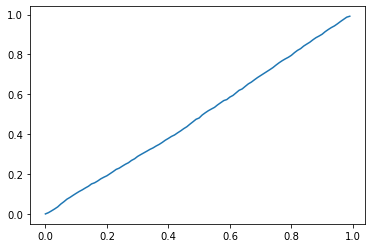

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
eps = np.zeros(100)
err = np.zeros(100)
for k in range(100):
    eps[k] = k/100
    err[k] = 0
    for j in range(len(y_test)):
        if(p_value[j,int(y_test[j])]<= eps[k]):
            err[k] = err[k]+1
    err[k] = err[k]/len(y_test)
plt.plot(eps,err)
total = 0    
for i in range(len(y_test)):
    k = y_test[i]
    for j in range(len(labels)):
        if k!= j:
            total =total+ p_value[i,j]
avg_false_p = total/(len(p_value)*(len(labels)-1))
print('Average False P-value is ',avg_false_p)

Summary

Task 3: 
        
        Generalisation accuracy for Wine Dataset = 0.6923076923076923

        Generalisation accuracy for USPS Dataset = 0.9710317129736762
        
Task 4: 

        Test error rate for Wine Dataset = 0.37777777777777777

        Test error rate for USPS Dataset = 0.02537634408602152
        
Task 6: 
         
        Test error rate for Wine Dataset using MinMax = 0.044444444444444446

        Test error rate for USPS Dataset using MinMax = 0.027526881720430108
        
        Test error rate for Wine Dataset using Normaliser = 0.06666666666666667
        
        Test error rate for USPS Dataset using Normaliser = 0.021505376344086023
        
        Test error rate for Wine Dataset using RobustScaler = 0.044444444444444446
        
        Test error rate for USPS Dataset using RobustScaler = 0.11612903225806452
        
        Test error rate for Wine Dataset using StandardScaler = 0.06666666666666667
        
        Test error rate for USPS Dataset using StandardScaler = 0.033118279569892474
        
        
Task 7: 

        Average False P-value for Wine dataset = 0.008706467661691555

        Average False P-value for USPS dataset = 0.004598339146014124

Observations: 
1) The Wine Dataset being a small dataset can give better test-error rate for StandardScaler, MinMax Scaler if random state is changed. 

2) With the increase in size of the dataset, the difference between generalisation accuracy and accuracy on test-set becomes lesser. Increased size of training set has reduced the error rate greatly as well.

3) The caliberation curve is affected by the size of our training set significantly, it can be apparant from the caliberation curve we obtained from the two datasets. USPS Dataset being an enormous dataset provides a caliberation curve which is close to the ideal calioberation curve i.e  the main diagonal of the square [0,1]^2. 



***Comment:*** I tried to find the optimal number of folds for the crossconformal predictor, It is generally advised to use k =[5,10] number of folds for crossvalidation. Since the approach for conformal predictors is different than other machine learning algorithms, I am not sure if it is the right thing to use the same values of K. But, I found that for these values of K, the validity and efficiency were achevied. Using USPS dataset, I found K =10 to be the optimal number of folds. I also tried to do something like K = n, number of folds where n = size of training set which I beleived to work as Leave-one-out counterpart for the cross-confromal predictors, but the K-fold library did not let me do that. I tried some other ways and using smaller dataset, I found that for that setting the validity of our cross-conformal predictior may be violated.